## Installing Detectron2

In [ ]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

#/Users/huzaifa/Documents/GitHub/FYP/Detectron/detectron2.ipynb

## Imports


In [1]:
import torchvision
import os
import json
import csv
import math
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sklearn.model_selection import train_test_split
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.data import DatasetCatalog, MetadataCatalog
from pycocotools import mask as mask_utils
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from detectron_dataset_skip_masks import GlaucomaDataset3 

## HyperParameters

In [2]:
root_dirs = [""]
val_dir = [ ""]
lr = 1e-4
batch_size = 1
num_workers = 4
total_epoch = 10200
max_images=None
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

## Registering Dataset 

In [3]:
# Register your dataset to Detectron2's DatasetCatalog
def register_glaucoma_dataset():
    # train_set = GlaucomaDataset2(root_dirs, split='train', max_images=max_images)
    train_set = GlaucomaDataset3(root_dirs, max_images=max_images)
    train_data, test_data = train_test_split(train_set, random_state=42, test_size=0.2)
    
    # Register datasets to Detectron2
    DatasetCatalog.register("glaucoma_train", lambda: train_data)
    DatasetCatalog.register("glaucoma_test", lambda: test_data)

    MetadataCatalog.get("glaucoma_train").set(thing_classes=["Optic Disc", "Optic Cup"])
    MetadataCatalog.get("glaucoma_test").set(thing_classes=["Optic Disc", "Optic Cup"])

register_glaucoma_dataset()

Succesfully loaded train dataset.                                                  


/Users/huzaifa/Documents/GitHub/FYP/Detectron/detectron_dataset_skip_masks.py:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])


## Detectron2 Configuration

In [4]:
# Detectron2 model configuration and training
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("glaucoma_train",)
cfg.DATASETS.TEST = ("glaucoma_test",)
cfg.INPUT.MASK_FORMAT = "bitmask"

# image size for training
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MAX_SIZE_TRAIN = 1024

# image size for testing
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1024

cfg.DATALOADER.NUM_WORKERS = num_workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = lr
cfg.SOLVER.MAX_ITER = total_epoch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # Optic Disc, Optic Cup

## Visualizing Data

In [6]:
# from detectron2.data import build_detection_train_loader
# import matplotlib.pyplot as plt
# import numpy as np
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog

# # Create a data loader
# train_data_loader = build_detection_train_loader(cfg)
# train_metadata = MetadataCatalog.get("smdg_test")

# # Assuming "glaucoma_train" is the name of your training dataset
# train_dataset = DatasetCatalog.get("glaucoma_train")
# print("Number of samples in training set: ", len(train_dataset))
# test_set = DatasetCatalog.get("smdg_test")
# print("Number of samples in test set: ", len(test_set))

# # Loop to visualize first 5 samples
# for i, batch in enumerate(train_data_loader):
#     if i >= 1:
#         break
    
#     # Each 'batch' is a list of dicts. We'll use the first (and only) dict in our case
#     data_sample = batch[0]
    
#     # Retrieve image from data_sample
#     img = np.array(data_sample["image"].permute(1, 2, 0).cpu().detach().numpy(), dtype=np.uint8)
    
#     # Annotations
#     annotations = data_sample["instances"].to("cpu")
    
#     # Masks from annotations
#     masks = annotations.gt_masks.tensor.numpy()
#     labels = annotations.gt_classes.cpu().numpy()
    
#     # Visualize
#     visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)
#     vis_output = visualizer.draw_instance_predictions(annotations)

#     # Create a figure with sub-plots
#     fig, axes = plt.subplots(1, 2, figsize=(6, 6))

#     # Show the image with annotations
#     axes[0].imshow(vis_output.get_image()[:, :, ::-1])
#     axes[0].set_title(f"Data sample {i} with Annotations")
#     axes[0].axis("off")

#     # Create an empty mask
#     colored_masks = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)

#     for j in range(masks.shape[0]):
#         label = labels[j]
#         mask = masks[j]
#         if label == 0:  # Assuming label 0 is for OD
#             colored_masks[mask == 1] = [255, 0, 0]  # Red for OD
#         elif label == 1:  # Assuming label 1 is for OC
#             colored_masks[mask == 1] = [0, 255, 0]  # Green for OC

#     # Show the masks
#     axes[1].imshow(colored_masks)
#     axes[1].set_title(f"Data sample {i} Masks")

#     # Show the figure
#     plt.show()


## Trainer setup


In [7]:
# Trainer setup
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[04/03 09:48:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

## Start training


In [ ]:
# trainer.train()

## Testing Predictions

In [10]:
# Assuming cfg is your trained model's config
# Load the model weights
cfg.MODEL.WEIGHTS = "./output/model_final.pth"

# Create a predictor instance
predictor = DefaultPredictor(cfg)

# Get test data loader

# Create COCO Evaluator
evaluator = COCOEvaluator("glaucoma_test", output_dir="./output")

# Build the test loader
test_loader = build_detection_test_loader(cfg, "glaucoma_test")
test_metadata = MetadataCatalog.get("glaucoma_test")

print(test_loader.dataset[0].keys())

# Run Evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print(eval_results)
print("Average Precision (AP):", eval_results["bbox"]["AP"])
print("Average Precision at IoU 0.50 (AP50):", eval_results["bbox"]["AP50"])
print("Average Precision at IoU 0.75 (AP75):", eval_results["bbox"]["AP75"])
print("Medium object AP (APm):", eval_results["bbox"]["APm"])
print("Large object AP (APl):", eval_results["bbox"]["APl"])


[04/03 09:50:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[04/03 09:50:12 d2.evaluation.coco_evaluation]: Trying to convert 'glaucoma_test' to COCO format ...
WARNING [04/03 09:50:12 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/glaucoma_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[04/03 09:50:12 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
| Optic Disc | 204          | Optic Cup  | 158          |
|            |              |            |              |
|   total    | 362          |            |              |
[04/03 09:50:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='choice')]
[04/03 09:50:12 d

/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/03 09:50:28 d2.evaluation.evaluator]: Inference done 11/204. Dataloading: 0.0003 s/iter. Inference: 1.2805 s/iter. Eval: 0.0057 s/iter. Total: 1.2865 s/iter. ETA=0:04:08
[04/03 09:50:33 d2.evaluation.evaluator]: Inference done 15/204. Dataloading: 0.0003 s/iter. Inference: 1.2982 s/iter. Eval: 0.0051 s/iter. Total: 1.3037 s/iter. ETA=0:04:06
[04/03 09:50:39 d2.evaluation.evaluator]: Inference done 19/204. Dataloading: 0.0004 s/iter. Inference: 1.3122 s/iter. Eval: 0.0051 s/iter. Total: 1.3178 s/iter. ETA=0:04:03
[04/03 09:50:44 d2.evaluation.evaluator]: Inference done 23/204. Dataloading: 0.0004 s/iter. Inference: 1.3261 s/iter. Eval: 0.0051 s/iter. Total: 1.3317 s/iter. ETA=0:04:01
[04/03 09:50:50 d2.evaluation.evaluator]: Inference done 27/204. Dataloading: 0.0004 s/iter. Inference: 1.3292 s/iter. Eval: 0.0050 s/iter. Total: 1.3347 s/iter. ETA=0:03:56
[04/03 09:50:55 d2.evaluation.evaluator]: Inference done 31/204. Dataloading: 0.0004 s/iter. Inference: 1.3299 s/iter. Eval: 0.005

## Model loss and other values

In [11]:
import json
import matplotlib.pyplot as plt

data=[]
#read metric.josn file
with open('output/metrics.json') as f:
    #read line by line
    for line in f:
        #convert to json
        data.append(line)

fast_rcnn_cls_accuracy=[]
fast_rcnn_false_negative=[]
fast_rcnn_fg_cls_accuracy=[]
iteration=[]
loss_box_reg=[]
loss_cls=[]
loss_mask=[]
loss_rpn_cls=[]
loss_rpn_loc=[]
mask_rcnn_accuracy=[]
mask_rcnn_false_negative=[]
mask_rcnn_false_positive=[]
total_loss=[]

for json_str in data:
    result=json.loads(json_str)
    fast_rcnn_cls_accuracy.append(result['fast_rcnn/cls_accuracy'])
    fast_rcnn_false_negative.append(result['fast_rcnn/false_negative'])
    fast_rcnn_fg_cls_accuracy.append(result['fast_rcnn/fg_cls_accuracy'])
    iteration.append(result['iteration'])
    loss_box_reg.append(result['loss_box_reg'])
    loss_cls.append(result['loss_cls'])
    loss_mask.append(result['loss_mask'])
    loss_rpn_cls.append(result['loss_rpn_cls'])
    loss_rpn_loc.append(result['loss_rpn_loc'])
    mask_rcnn_accuracy.append(result['mask_rcnn/accuracy'])
    mask_rcnn_false_negative.append(result['mask_rcnn/false_negative'])
    mask_rcnn_false_positive.append(result['mask_rcnn/false_positive'])
    total_loss.append(result['total_loss'])

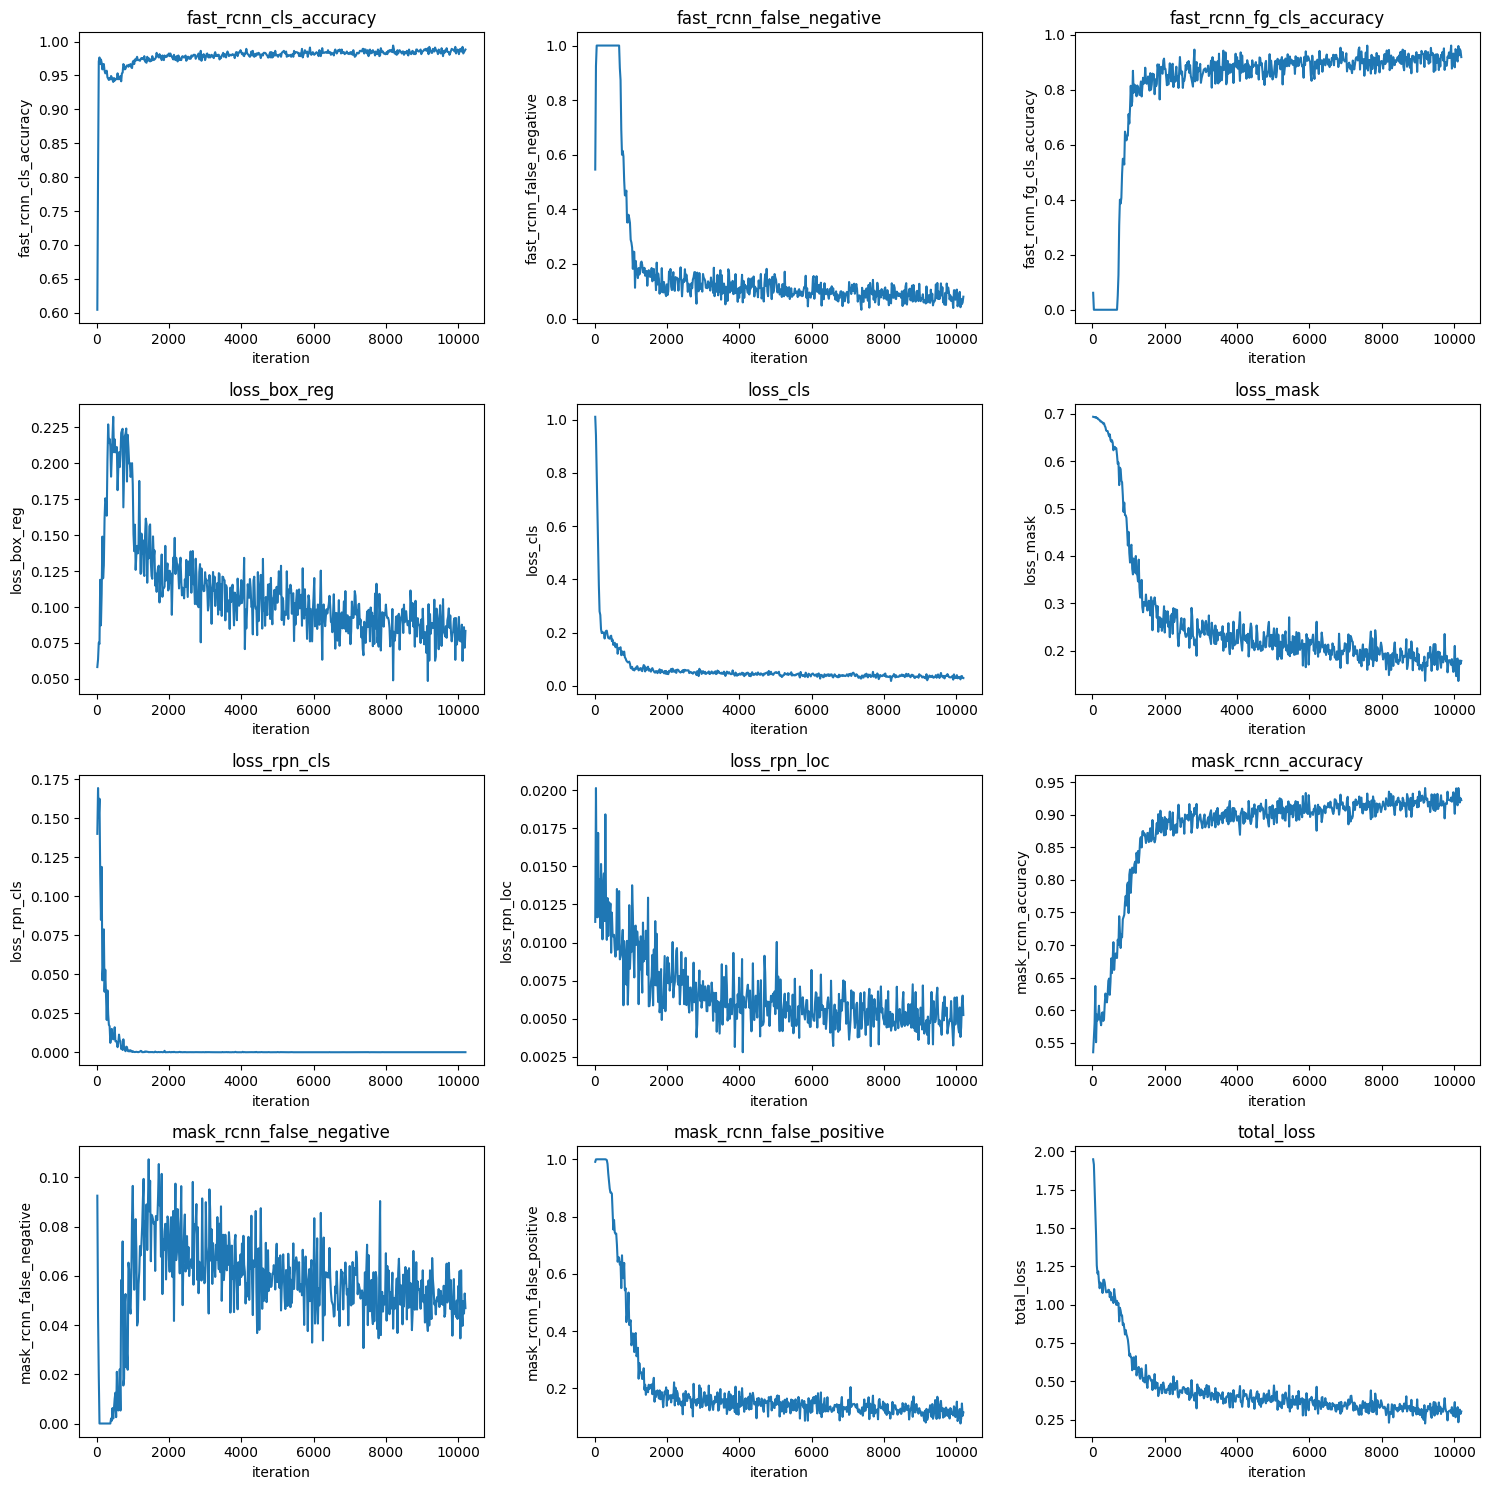

In [12]:
import matplotlib.pyplot as plt

# Assuming 'iteration' is the common x-axis for all plots

# Create a 4x3 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Plot fast_rcnn_cls_accuracy
axs[0, 0].plot(iteration, fast_rcnn_cls_accuracy)
axs[0, 0].set_title('fast_rcnn_cls_accuracy')
axs[0, 0].set(xlabel='iteration', ylabel='fast_rcnn_cls_accuracy')

# Plot fast_rcnn_false_negative
axs[0, 1].plot(iteration, fast_rcnn_false_negative)
axs[0, 1].set_title('fast_rcnn_false_negative')
axs[0, 1].set(xlabel='iteration', ylabel='fast_rcnn_false_negative')

# Plot fast_rcnn_fg_cls_accuracy
axs[0, 2].plot(iteration, fast_rcnn_fg_cls_accuracy)
axs[0, 2].set_title('fast_rcnn_fg_cls_accuracy')
axs[0, 2].set(xlabel='iteration', ylabel='fast_rcnn_fg_cls_accuracy')

# Plot loss_box_reg
axs[1, 0].plot(iteration, loss_box_reg)
axs[1, 0].set_title('loss_box_reg')
axs[1, 0].set(xlabel='iteration', ylabel='loss_box_reg')

# Plot loss_cls
axs[1, 1].plot(iteration, loss_cls)
axs[1, 1].set_title('loss_cls')
axs[1, 1].set(xlabel='iteration', ylabel='loss_cls')

# Plot loss_mask
axs[1, 2].plot(iteration, loss_mask)
axs[1, 2].set_title('loss_mask')
axs[1, 2].set(xlabel='iteration', ylabel='loss_mask')

# Plot loss_rpn_cls
axs[2, 0].plot(iteration, loss_rpn_cls)
axs[2, 0].set_title('loss_rpn_cls')
axs[2, 0].set(xlabel='iteration', ylabel='loss_rpn_cls')

# Plot loss_rpn_loc
axs[2, 1].plot(iteration, loss_rpn_loc)
axs[2, 1].set_title('loss_rpn_loc')
axs[2, 1].set(xlabel='iteration', ylabel='loss_rpn_loc')

# Plot mask_rcnn_accuracy
axs[2, 2].plot(iteration, mask_rcnn_accuracy)
axs[2, 2].set_title('mask_rcnn_accuracy')
axs[2, 2].set(xlabel='iteration', ylabel='mask_rcnn_accuracy')

# Plot mask_rcnn_false_negative
axs[3, 0].plot(iteration, mask_rcnn_false_negative)
axs[3, 0].set_title('mask_rcnn_false_negative')
axs[3, 0].set(xlabel='iteration', ylabel='mask_rcnn_false_negative')

# Plot mask_rcnn_false_positive
axs[3, 1].plot(iteration, mask_rcnn_false_positive)
axs[3, 1].set_title('mask_rcnn_false_positive')
axs[3, 1].set(xlabel='iteration', ylabel='mask_rcnn_false_positive')

# Plot total_loss
axs[3, 2].plot(iteration, total_loss)
axs[3, 2].set_title('total_loss')
axs[3, 2].set(xlabel='iteration', ylabel='total_loss')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


## Calculating Custom IOU's 

In [13]:
gt_dataset = DatasetCatalog.get("glaucoma_test")
test_metadata = MetadataCatalog.get("glaucoma_test")

# print(len(gt_dataset))

filename=[]
optic_disc_mask_predicted=[]
optic_cup_mask_predicted=[]

optic_disc_mask_ground=[]
optic_cup_mask_ground=[]

In [ ]:
# for idx in range(len(gt_dataset)):  
#     data = gt_dataset[idx]

#     file_name = data["file_name"]
#     filename.append(file_name)
#     img = cv2.imread(file_name)
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Initialize masks to None
#     optic_disc_mask_gt = np.zeros_like(img[:, :, 0])
#     optic_cup_mask_gt = np.zeros_like(img[:, :, 0])

#     # Get the corresponding ground truth masks
#     for ann in data['annotations']:
#         if ann['category_id'] == 0:  # Optic disc
#             optic_disc_mask_gt = mask_utils.decode(ann['segmentation'])
#         elif ann['category_id'] == 1:  # Optic cup
#             optic_cup_mask_gt = mask_utils.decode(ann['segmentation'])

#     optic_cup_mask_ground.append(optic_cup_mask_gt)
#     optic_disc_mask_ground.append(optic_disc_mask_gt)

#     # Predict the masks
#     outputs = predictor(img)
#     pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
#     pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
#     scores = outputs["instances"].scores.to("cpu").numpy()
    
#     # Select the highest confidence mask for optic disc (class 0) and optic cup (class 1)
#     optic_disc_mask_pred = np.zeros_like(img[:, :, 0])
#     optic_cup_mask_pred = np.zeros_like(img[:, :, 0])

#     if np.any(pred_classes == 0):
#         optic_disc_idx = pred_classes == 0
#         highest_disc_score_idx = np.argmax(scores[optic_disc_idx])
#         optic_disc_mask_pred = pred_masks[optic_disc_idx][highest_disc_score_idx]
#     if np.any(pred_classes == 1):
#         optic_cup_idx = pred_classes == 1
#         highest_cup_score_idx = np.argmax(scores[optic_cup_idx])
#         optic_cup_mask_pred = pred_masks[optic_cup_idx][highest_cup_score_idx]

#     optic_disc_mask_predicted.append(optic_disc_mask_pred)
#     optic_cup_mask_predicted.append(optic_cup_mask_pred)

#     # Plot ground truth and predictions side by side
#     # fig, ax = plt.subplots(1, 5, figsize=(25, 10))
#     # ax[0].imshow(img_rgb)
#     # ax[0].set_title(f'{idx+1}: Original Image: {file_name}')
#     # ax[0].axis('off')
#     # ax[1].imshow(optic_disc_mask_gt, cmap='gray')
#     # ax[1].set_title('Ground Truth Optic Disc')
#     # ax[1].axis('off')
#     # ax[2].imshow(optic_cup_mask_gt, cmap='gray')
#     # ax[2].set_title('Ground Truth Optic Cup')
#     # ax[2].axis('off')
#     # ax[3].imshow(optic_disc_mask_pred, cmap='gray')
#     # ax[3].set_title('Predicted Optic Disc')
#     # ax[3].axis('off')
#     # ax[4].imshow(optic_cup_mask_pred, cmap='gray')
#     # ax[4].set_title('Predicted Optic Cup')
#     # ax[4].axis('off')

# # plt.show()

In [ ]:
# import numpy as np
# import cv2
# import pycocotools.mask as mask_utils

# class EvaluationMetric:
#     def __init__(self):
#         pass

#     def calculate_iou(self, gt_mask, pred_mask):
#         """
#         Calculate the Intersection over Union (IoU) between the predicted mask and the ground truth mask.

#         :param gt_mask: Ground truth mask, can be None if the mask is not present
#         :param pred_mask: Predicted mask, can be None if the mask is not present
#         :return: IoU score, 0 if either of the masks is not present or there is no overlap
#         """
#         if gt_mask is None or pred_mask is None:
#             return 0  # Return 0 if there is no corresponding mask

#         # Ensure the masks are boolean
#         gt_mask_bool = gt_mask.astype(bool)
#         pred_mask_bool = pred_mask.astype(bool)

#         # Calculate intersection and union
#         intersection = np.logical_and(gt_mask_bool, pred_mask_bool).sum()
#         union = np.logical_or(gt_mask_bool, pred_mask_bool).sum()

#         # Compute IoU
#         iou = intersection / float(union) if union != 0 else 0

#         return iou

# evaluation_metric = EvaluationMetric()

# # Function to get masks and calculate IoUs for the whole test set for multiple thresholds
# def calculate_iou_for_test_set(gt_dataset, predictor, iou_thresholds):
#     iou_scores = {threshold: {'optic_disc': [], 'optic_cup': []} for threshold in iou_thresholds}

#     for data in gt_dataset:
#         file_name = data["file_name"]
#         img = cv2.imread(file_name)

#         # Predict the masks
#         outputs = predictor(img)
#         pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
#         pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()

#         # Initialize ground truth masks
#         optic_disc_mask_gt = None
#         optic_cup_mask_gt = None

#         # Get ground truth masks
#         for ann in data['annotations']:
#             if ann['category_id'] == 0:  # Optic disc
#                 optic_disc_mask_gt = mask_utils.decode(ann['segmentation'])
#             elif ann['category_id'] == 1:  # Optic cup
#                 optic_cup_mask_gt = mask_utils.decode(ann['segmentation'])

#         # Initialize predicted masks
#         optic_disc_mask_pred = None
#         optic_cup_mask_pred = None

#         # Get predicted masks for optic disc and cup
#         if np.any(pred_classes == 0):
#             optic_disc_mask_pred = pred_masks[pred_classes == 0].max(axis=0)
#         if np.any(pred_classes == 1):
#             optic_cup_mask_pred = pred_masks[pred_classes == 1].max(axis=0)

#         # Calculate IoU for optic disc and optic cup for all thresholds
#         iou_disc = evaluation_metric.calculate_iou(optic_disc_mask_gt, optic_disc_mask_pred)
#         iou_cup = evaluation_metric.calculate_iou(optic_cup_mask_gt, optic_cup_mask_pred)

#         # Append the actual IoU values to the iou_scores lists
#         for threshold in iou_thresholds:
#             iou_scores[threshold]['optic_disc'].append(iou_disc >= threshold)
#             iou_scores[threshold]['optic_cup'].append(iou_cup >= threshold)

#     # Calculate the mean IoU for all thresholds for optic disc and optic cup
#     mean_iou_scores = {
#         threshold: {
#             'optic_disc': np.mean(iou_scores[threshold]['optic_disc']),
#             'optic_cup': np.mean(iou_scores[threshold]['optic_cup'])
#         } for threshold in iou_thresholds
#     }

#     return mean_iou_scores

In [ ]:
# # Sample usage (you need to define gt_dataset and predictor according to your application):
# iou_thresholds = [0.4, 0.5, 0.6]
# mean_iou_scores = calculate_iou_for_test_set(gt_dataset, predictor, iou_thresholds)

# for threshold in iou_thresholds:
#     disc_iou = mean_iou_scores[threshold]['optic_disc']
#     cup_iou = mean_iou_scores[threshold]['optic_cup']
#     print(f"Average IoU for Optic Disc at {threshold}: {disc_iou}")
#     print(f"Average IoU for Optic Cup at {threshold}: {cup_iou if cup_iou is not None else 'No optic cup detections'}")

## SMDG Dataset Loading

In [19]:
path="/Users/huzaifa/Downloads/smdg/full-fundus/full-fundus"

#laod images in the folder
def load_images_from_folder(folder):
    images = []
    files=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            files.append(filename)
            images.append(img)
    return images, files

#load images
images,files = load_images_from_folder(path)
print(len(images),len(files))

12449 12449


## Metrics Calculation

### Empty Lists

In [34]:
optic_cup_diameter_predicted=[]
optic_cup_diameter_ground=[]

optic_disc_diameter_predicted=[]
optic_disc_diameter_ground=[]

cdr_predicted=[]
cdr_ground=[]

isnt_predicted=[]
isnt_ground=[]

inferior_predicted=[]
superior_predicted=[]
nasal_predicted=[]
temporal_predicted=[]

inferior_ground=[]
superior_ground=[]
nasal_ground=[]
temporal_ground=[]

### ISNT

### ISNT Supportive Functions

In [35]:
def averageDistanceDifference(points_outer,points_inner, center,stats):
    distances_outer = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x, y in points_outer]
    distance_outer= np.mean(distances_outer) if distances_outer else 0

    distances_inner = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x, y in points_inner]
    distance_inner= np.mean(distances_inner) if distances_inner else 0

    if stats:
        print("Outer Distance from Center: ",distance_outer)
        print("Inner Distance from Center: ",distance_inner)
        print("Difference: ",(distance_outer-distance_inner))

    return round(distance_outer-distance_inner,3)
    

def findTopLeftCorner(mask):
    y, x = np.where(mask == 1)
    x_min = x.min()
    y_max = y.max()
    return x_min, y_max

def findTopRightCorner(mask):
    y, x = np.where(mask == 1)
    x_max = x.max()
    y_max = y.max()
    return x_max, y_max

def findBottomLeftCorner(mask):
    y, x = np.where(mask == 1)
    x_min = x.min()
    y_min = y.min()
    return x_min, y_min

def findBottomRightCorner(mask):
    y, x = np.where(mask == 1)
    x_max = x.max()
    y_min = y.min()
    return x_max, y_min


def findTopmostPoint(mask):
    y, x = np.where(mask == 1)
    if len(y) == 0:
        return None
    y_top = y.min()
    x_top = x[y.argmin()]
    return x_top, y_top

def findLeftmostPoint(mask):
    y, x = np.where(mask == 1)
    if len(x) == 0:
        return None
    x_left = x.min()
    y_left = y[x.argmin()]
    return x_left, y_left

def findRightmostPoint(mask):
    y, x = np.where(mask == 1)
    if len(x) == 0:
        return None
    x_right = x.max()
    y_right = y[x.argmax()]
    return x_right, y_right

def findBottommostPoint(mask):
    y, x = np.where(mask == 1)
    if len(y) == 0:
        return None
    y_bottom = y.max()
    x_bottom = x[y.argmax()]
    return x_bottom, y_bottom


def get_outermost_points(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return []  # No contours found

    max_contour = max(contours, key=cv2.contourArea)
    outermost_points = max_contour[:, 0, :]
    return outermost_points

def getEightCorners(mask):
    right_top = findTopRightCorner(mask)
    right_bottom = findBottomRightCorner(mask)
    left_top = findTopLeftCorner(mask)
    left_bottom = findBottomLeftCorner(mask)

    top= findTopmostPoint(mask)
    bottom= findBottommostPoint(mask)
    left= findLeftmostPoint(mask)
    right= findRightmostPoint(mask)

    #get center from top_right and bottom_left point
    center_x1=(right_top[0]+left_bottom[0])/2
    center_y1=(right_top[1]+left_bottom[1])/2

    #get center from top_left and bottom_right point
    center_x2=(left_top[0]+right_bottom[0])/2
    center_y2=(left_top[1]+right_bottom[1])/2

    #assert both are same
    assert(center_x1==center_x2)
    assert(center_y1==center_y2)

    center=(center_x1,center_y1)

    return top, bottom, left, right, right_top, right_bottom, left_top, left_bottom, center


def pointsInSector(center,point1,point2,points):
    angle1=math.atan2(point1[1]-center[1],point1[0]-center[0])
    angle2=math.atan2(point2[1]-center[1],point2[0]-center[0])
 
    angle1=(angle1 +2 * math.pi)%(2*math.pi)
    angle2=(angle2 +2 * math.pi)%(2*math.pi)
 
    sorted_points=sorted(points,key=lambda p:math.atan2(p[1]-center[1],p[0]-center[0]))
 
    points_in_sector=[]
    for point in sorted_points:
        angle_point=math.atan2(point[1]-center[1],point[0]-center[0])
        angle_point=(angle_point+2*math.pi)% (2*math.pi)
       
        if angle1<=angle_point<=angle2:
            points_in_sector.append(point)
   
    return points_in_sector

### ISNT Function

In [36]:

def getISNTValues(mask_disc,mask_cup, leftOrRight, visualize=False,stats=False):
    mask_disc=np.uint8(mask_disc)
    mask_cup=np.uint8(mask_cup)

    #if disc and cup mask are empty/null
    if not np.any(mask_disc) and not np.any(mask_cup):
        return "Both Masks Empty"
    
    cup_missing=True
    if not np.any(mask_cup):
        cup_missing=False

    # Get the corners
    top, bottom, left, right, right_bottom, right_top, left_bottom, left_top,center=getEightCorners(mask_disc)
    
    #for disc mask
    outer_border_points = get_outermost_points(mask_disc)

    inferior_points_outer=pointsInSector(center,right_bottom,left_bottom,outer_border_points)
    superior_points_outer=pointsInSector(center,left_top,right_top,outer_border_points)

    nasal_points_outer=pointsInSector(center,right_bottom,right_top,outer_border_points)
    nasal_points_outer = [point for point in outer_border_points if not any(np.array_equal(point, nasal_point) for nasal_point in nasal_points_outer)]

    temporal_points_outer=pointsInSector(center,left_bottom,left_top,outer_border_points)
    
    #for cup mask
    inner_border_points = get_outermost_points(mask_cup)
    
    inferior_points_inner=pointsInSector(center,right_bottom,left_bottom,inner_border_points)
    superior_points_inner=pointsInSector(center,left_top,right_top,inner_border_points)

    nasal_points_inner=pointsInSector(center,right_bottom,right_top,inner_border_points)
    nasal_points_inner = [point for point in inner_border_points if not any(np.array_equal(point, nasal_point) for nasal_point in nasal_points_inner)]
   
    temporal_points_inner=pointsInSector(center,left_bottom,left_top,inner_border_points)
    
    dist1=averageDistanceDifference(inferior_points_outer,inferior_points_inner,center,stats)
    dist2=averageDistanceDifference(superior_points_outer,superior_points_inner,center,stats)
    dist3=averageDistanceDifference(nasal_points_outer,nasal_points_inner,center,stats)
    dist4=averageDistanceDifference(temporal_points_outer,temporal_points_inner,center,stats)

    if stats:
        print("Mask\tI\tS\tN\tT\tTot")
        print(f"Disc\t{len(inferior_points_outer)}\t{len(superior_points_outer)}\t{len(nasal_points_outer)}\t{len(temporal_points_outer)}\t{len(inferior_points_outer)+len(superior_points_outer)+len(nasal_points_outer)+len(temporal_points_outer)}")
        print(f"Cup\t{len(inferior_points_inner)}\t{len(superior_points_inner)}\t{len(nasal_points_inner)}\t{len(temporal_points_inner)}\t{len(inferior_points_inner)+len(superior_points_inner)+len(nasal_points_inner)+len(temporal_points_inner)}")
        print()
        print(f"\t{dist1}\t{dist2}\t{dist3}\t{dist4}")
        print()
        print("Total Points for Disc Should Be: ", len(outer_border_points))
        print("Total Points for Cup Should Be: ", len(inner_border_points))


    if visualize:
        fig, axs = plt.subplots(2, 4, figsize=(15, 8))

        #plot mask
        axs[0][0].imshow(mask_disc, cmap='gray')
        axs[0][0].plot(outer_border_points[:, 0], outer_border_points[:, 1], linewidth=2,color='red')
        if inner_border_points != []:
            axs[0][0].plot(inner_border_points[:, 0], inner_border_points[:, 1], linewidth=2,color='red')
        axs[0][0].set_title('Mask+Contours')
        axs[0][0].axis('on')
    
        #plot mask
        axs[0][1].imshow(mask_disc, cmap='gray')
        axs[0][1].scatter(outer_border_points[:, 0], outer_border_points[:, 1], s=1,color='red')
        if inner_border_points != []:
            axs[0][1].scatter(inner_border_points[:, 0], inner_border_points[:, 1], s=1,color='red')
        axs[0][1].set_title('Image+Contours')
        axs[0][1].axis('on')

        #plot mask with eight corner points
        axs[0][2].imshow(mask_disc, cmap='gray')
        axs[0][2].scatter(top[0], top[1], s=10,color='red')
        axs[0][2].scatter(bottom[0], bottom[1], s=10,color='red')
        axs[0][2].scatter(left[0], left[1], s=10,color='red')
        axs[0][2].scatter(right[0], right[1], s=10,color='red')
        axs[0][2].scatter(right_top[0], right_top[1], s=10,color='red')
        axs[0][2].scatter(right_bottom[0], right_bottom[1], s=10,color='red')
        axs[0][2].scatter(left_top[0], left_top[1], s=10,color='red')
        axs[0][2].scatter(left_bottom[0], left_bottom[1], s=10,color='red')
        axs[0][2].scatter(center[0], center[1], s=10,color='red')
        axs[0][2].set_title('Image+Corner Points+Center')
        axs[0][2].axis('on')

        axs[0][3].imshow(mask_disc, cmap='gray')
        axs[0][3].scatter(center[0], center[1], s=10,color='red')
        axs[0][3].plot([left_top[0], right_bottom[0]], [left_top[1], right_bottom[1]], linestyle='--', color='gray', label='Diagonal 1')
        axs[0][3].plot([left_bottom[0], right_top[0]], [left_bottom[1], right_top[1]], linestyle='--', color='gray', label='Diagonal 2')
        axs[0][3].set_title('Image+Diagnol+Center')
        axs[0][3].axis('on')

        #plot sector points
        axs[1][0].imshow(mask_disc, cmap='gray')
        axs[1][0].scatter(right_bottom[0], right_bottom[1], s=10,color='red')
        axs[1][0].scatter(left_bottom[0], left_bottom[1], s=10,color='red')
        if inferior_points_outer:
            axs[1][0].scatter(*zip(*inferior_points_outer), color='blue', label=f'Inferior')
        axs[1][0].set_title('Inferior/Lower')
        if inferior_points_inner:
            axs[1][0].scatter(*zip(*inferior_points_inner), color='orange', label=f'Inferior')
            axs[1][0].set_title(f'Inferior/Lower: {dist1}')
        axs[1][0].axis('on')

        axs[1][1].imshow(mask_disc, cmap='gray')
        axs[1][1].scatter(right_top[0], right_top[1], s=10,color='red')
        axs[1][1].scatter(left_top[0], left_top[1], s=10,color='red')
        if superior_points_outer:
            axs[1][1].scatter(*zip(*superior_points_outer), color='blue', label=f'Superior')
        axs[1][1].set_title('Superior/Top')
        if superior_points_inner:
            axs[1][1].scatter(*zip(*superior_points_inner), color='orange', label=f'Superior') 
            axs[1][1].set_title(f'Superior/Top: {dist2}')
        axs[1][1].axis('on')

        axs[1][2].imshow(mask_disc, cmap='gray')
        axs[1][2].scatter(right_top[0], right_top[1], s=10,color='red')
        axs[1][2].scatter(right_bottom[0], right_bottom[1], s=10,color='red')
        if nasal_points_outer:
            axs[1][2].scatter(*zip(*nasal_points_outer), color='blue', label=f'Nasal')
        axs[1][2].set_title('Nasal/Right')
        if nasal_points_inner:
            axs[1][2].scatter(*zip(*nasal_points_inner), color='orange', label=f'Nasal')
            axs[1][2].set_title(f'Nasal/Right: {dist3}')
        axs[1][2].axis('on')

        axs[1][3].imshow(mask_disc, cmap='gray')
        axs[1][3].scatter(left_top[0], left_top[1], s=10,color='red')
        axs[1][3].scatter(left_bottom[0], left_bottom[1], s=10,color='red')
        if temporal_points_outer:
            axs[1][3].scatter(*zip(*temporal_points_outer), color='blue', label=f'Temporal')
        axs[1][3].set_title('Temporal/Left')
        if temporal_points_inner:
            axs[1][3].scatter(*zip(*temporal_points_inner), color='orange', label=f'Temporal')
            axs[1][3].set_title(f'Temporal/Left: {dist4}')
        axs[1][3].axis('on')
        plt.show()

    if leftOrRight.lower()=="left":
        return {'inferior':dist1,'superior':dist2,'nasal':dist4,'temporal':dist3,'cup':cup_missing}
    elif leftOrRight.lower()=="right":
        return {'inferior':dist1,'superior':dist2,'nasal':dist3,'temporal':dist4,'cup':cup_missing}


### CDR 

In [37]:
# def getCupDiscDiameter(mask):
#     dist_transform = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 5)
#     _, max_val, _, max_loc = cv2.minMaxLoc(dist_transform)
#     diameter = 2 * max_val

#     return diameter


# def getCupDiscDiameter2(mask):
#     mask_array = np.array(mask, dtype=bool)
#     column_sums = np.sum(mask_array, axis=0)
#     max_height = np.max(column_sums)
#     return max_height


def getDiameter(mask):
    highest_pixel=findTopmostPoint(mask)
    lowest_pixel=findBottommostPoint(mask)

    if highest_pixel is None or lowest_pixel is None:
        return 0

    diameter = math.sqrt((highest_pixel[0] - lowest_pixel[0]) ** 2 + (highest_pixel[1] - lowest_pixel[1]) ** 2)
    return diameter

In [38]:
def getCDR(disc_mask, cup_mask):
    disc_diameter = getDiameter(disc_mask)
    cup_diameter = getDiameter(cup_mask)

    cdr = cup_diameter / disc_diameter if disc_diameter != 0 else 0

    return cdr

## Read CSV to get Left/Right Eye & Ground Labels

In [ ]:
import csv
import pandas as pd

csv_file_path = 'G1020.csv'
csv_g1020=[]


with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    modified_rows = [[row[i] for i in range(3, len(row))] for row in csv_reader]

    # Read and print each row
    for row in modified_rows:
        csv_g1020.append(row)

print("Number of Rows in CSV: ",len(csv_g1020))
print("Number of Files: ",len(filename))
print()

csv_leftOrRight=[]
csv_groundLabel=[]

for i in range(len(filename)):
    for j in range(len(csv_g1020)):
        if filename[i].split('/')[1]==csv_g1020[j][0]:
            csv_leftOrRight.append(csv_g1020[j][1])
            csv_groundLabel.append(csv_g1020[j][3])

print("Number of leftOrRight: ",len(csv_leftOrRight))
print("Number of GrounfLabels: ",len(csv_groundLabel))



## Inference on SMDG

In [43]:
for i in range(len(images)):
    img = images[i]#cv2.imread(imagePath)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
    pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
    scores = outputs["instances"].scores.to("cpu").numpy()
    
    optic_disc_mask_pred = np.zeros_like(img[:, :, 0])
    optic_cup_mask_pred = np.zeros_like(img[:, :, 0])

    if np.any(pred_classes == 0):
        optic_disc_idx = pred_classes == 0
        highest_disc_score_idx = np.argmax(scores[optic_disc_idx])
        optic_disc_mask_pred = pred_masks[optic_disc_idx][highest_disc_score_idx]
        
    if np.any(pred_classes == 1):
        optic_cup_idx = pred_classes == 1
        highest_cup_score_idx = np.argmax(scores[optic_cup_idx])
        optic_cup_mask_pred = pred_masks[optic_cup_idx][highest_cup_score_idx]

    #optic_disc_diameter_predicted.append(getDiameter(optic_disc_mask_pred))
    #optic_cup_diameter_predicted.append(getDiameter(optic_cup_mask_pred))
    
    eye="Left"
    cdr=getCDR(optic_disc_mask_pred,optic_cup_mask_pred)
    isnt=getISNTValues(optic_disc_mask_pred,optic_cup_mask_pred, eye, visualize=False,stats=False)

    cdr_predicted.append(cdr)
    isnt_predicted.append(isnt)


print(len(cdr_predicted),len(isnt_predicted),len(inferior_predicted),len(superior_predicted),len(nasal_predicted),len(temporal_predicted))

## Metrics Calculation

### Disc/Cup Diameter, CDR ISNT

In [ ]:

for i in range(len(gt_dataset)):
    optic_cup_diameter_predicted.append(getDiameter(optic_cup_mask_predicted[i]))
    #optic_cup_diameter_ground.append(getDiameter(optic_cup_mask_ground[i]))

    optic_disc_diameter_predicted.append(getDiameter(optic_disc_mask_predicted[i]))
    #optic_disc_diameter_ground.append(getDiameter(optic_disc_mask_ground[i]))

    #cdr_predicted.append(getCDR(optic_disc_mask_predicted[i], optic_cup_mask_predicted[i]))
    #cdr_ground.append(getCDR(optic_disc_mask_ground[i], optic_cup_mask_ground[i]))

    #isnt_ground=getISNTValues(optic_disc_mask_ground[i],optic_cup_mask_ground[i],csv_leftOrRight[i],visualize=False,stats=False)
    #isnt_predicted=getISNTValues(optic_disc_mask_predicted[i],optic_cup_mask_predicted[i],csv_leftOrRight[i],visualize=False,stats=False)

    #inferior_ground.append(isnt_ground['inferior'])
    #superior_ground.append(isnt_ground['superior'])
    #nasal_ground.append(isnt_ground['nasal'])
    #temporal_ground.append(isnt_ground['temporal'])

    inferior_predicted.append(isnt_predicted['inferior'])
    superior_predicted.append(isnt_predicted['superior'])
    nasal_predicted.append(isnt_predicted['nasal'])
    temporal_predicted.append(isnt_predicted['temporal'])



### Printing Metrics

In [ ]:
print("No.\tCup Dia GT\tCup Dia PRE\tDisc Dia GT\tDisc Dia PRE\tCDR GT\t\tCDR PRE\t\tInferior GT\tInferior PRE\tSuperior GT\tSuperior PRE\tNasal GT\tNasal PRE\tTemporal GT\tTemporal PRE\t\tISNT Followed\t\tShould Be Followed")
for i in range(len(optic_cup_diameter_predicted)):
    print(f"{i+1}\t{round(optic_cup_diameter_ground[i],2)}\t\t{round(optic_cup_diameter_predicted[i],2)}\t\t{round(optic_disc_diameter_ground[i],2)}\t\t{round(optic_disc_diameter_predicted[i],2)}\t\t{round(cdr_ground[i],2)}\t\t{round(cdr_predicted[i],2)}\t\t{round(inferior_ground[i],2)}\t\t{round(inferior_predicted[i],2)}\t\t{round(superior_ground[i],2)}\t\t{round(superior_predicted[i],2)}\t\t{round(nasal_ground[i],2)}\t\t{round(nasal_predicted[i],2)}\t\t{round(temporal_ground[i],2)}\t\t{round(temporal_predicted[i],2)}")


### Save to CSV

In [ ]:
isnt_followed_ground=0
isnt_followed_predicted=0

conflict=0

with open('output-new.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["No.", "Cup Dia GT", "Cup Dia PRE", "Disc Dia GT", "Disc Dia PRE", "CDR GT", "CDR PRE", "Inferior GT", "Inferior PRE", "Superior GT", "Superior PRE", "Nasal GT", "Nasal PRE", "Temporal GT", "Temporal PRE","ISNT Followed PRED","ISNT FOllowed GT"])
    for i in range(len(optic_cup_diameter_predicted)):
        followed=False
        should_be_followed=False

        if inferior_predicted[i]>=superior_predicted[i] and superior_predicted[i]>=nasal_predicted[i] and nasal_predicted[i]>=temporal_predicted[i]:
            isnt_followed_predicted+=1
            followed=True

        if inferior_ground[i]>=superior_ground[i] and superior_ground[i]>=nasal_ground[i] and nasal_ground[i]>=temporal_ground[i]:
            isnt_followed_ground+=1
            should_be_followed=True

        if followed!=should_be_followed:
            conflict+=1

        writer.writerow([i+1, round(optic_cup_diameter_ground[i],2), round(optic_cup_diameter_predicted[i],2), round(optic_disc_diameter_ground[i],2), round(optic_disc_diameter_predicted[i],2), round(cdr_ground[i],2), round(cdr_predicted[i],2), round(inferior_ground[i],2), round(inferior_predicted[i],2), round(superior_ground[i],2), round(superior_predicted[i],2), round(nasal_ground[i],2), round(nasal_predicted[i],2), round(temporal_ground[i],2), round(temporal_predicted[i],2), followed, should_be_followed])

print("Total: ",len(optic_cup_diameter_ground))
print()
print("ISNT Followed Ground: ",isnt_followed_ground)
print("ISNT Not Followed Ground: ",len(optic_cup_diameter_ground)-(isnt_followed_ground))
print()
print("ISNT Followed Predicted: ",isnt_followed_predicted)
print("ISNT Not Followed Predicted: ",len(optic_cup_diameter_ground)-(isnt_followed_predicted))
print()
print("ISNT Conflict: ",conflict)

### MAPE & STD

In [ ]:
def meanAbsolutePercentageError(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle cases where y_true is zero to avoid division by zero
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculate mean absolute percentage error
    mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) 

    return mape

def std(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle cases where y_true is zero to avoid division by zero
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculate standard deviation
    std_value = np.std(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

    return std_value


In [ ]:

print("Cup Diameter MAPE: ", meanAbsolutePercentageError(np.array(optic_cup_diameter_ground), np.array(optic_cup_diameter_predicted)))
print("Cup Diameter STD: ", std(np.array(optic_cup_diameter_ground), np.array(optic_cup_diameter_predicted)))

print("\nDisc Diameter MAPE: ", meanAbsolutePercentageError(np.array(optic_disc_diameter_ground), np.array(optic_disc_diameter_predicted)))
print("Disc Diameter STD: ", std(np.array(optic_disc_diameter_ground), np.array(optic_disc_diameter_predicted)))

print("\nCDR MAPE: ", meanAbsolutePercentageError(np.array(cdr_ground), np.array(cdr_predicted)))
print("CDR STD: ", std(np.array(cdr_ground), np.array(cdr_predicted)))

## Results

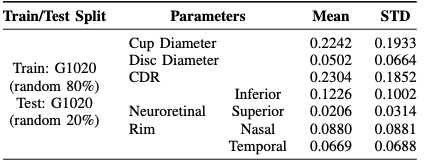

In [ ]:
print("Parameters\t\t\t Mean\t\t STD")
print("Cup Dia\t\t\t\t",round(meanAbsolutePercentageError(np.array(optic_cup_diameter_ground), np.array(optic_cup_diameter_predicted)),2), "\t\t", round(std(np.array(optic_cup_diameter_ground), np.array(optic_cup_diameter_predicted)),2))
print("Disc Dia\t\t\t",round(meanAbsolutePercentageError(np.array(optic_disc_diameter_ground), np.array(optic_disc_diameter_predicted)),2), "\t\t", round(std(np.array(optic_disc_diameter_ground), np.array(optic_disc_diameter_predicted)),2))
print("CDR\t\t\t\t",round(meanAbsolutePercentageError(np.array(cdr_ground), np.array(cdr_predicted)),2), "\t\t", round(std(np.array(cdr_ground), np.array(cdr_predicted)),2))

print("\n\t\tInferior\t",round(meanAbsolutePercentageError(np.array(inferior_ground), np.array(inferior_predicted)),2), "\t\t", round(std(np.array(inferior_ground), np.array(inferior_predicted)),2))
print("NR Rim\t\tSuperior\t",round(meanAbsolutePercentageError(np.array(superior_ground), np.array(superior_predicted)),2), "\t\t", round(std(np.array(superior_ground), np.array(superior_predicted)),2))
print("\t\tNasal\t\t",round(meanAbsolutePercentageError(np.array(nasal_ground), np.array(nasal_predicted)),2), "\t\t", round(std(np.array(nasal_ground), np.array(nasal_predicted)),2))
print("\t\tTemporal\t",round(meanAbsolutePercentageError(np.array(temporal_ground), np.array(temporal_predicted)),2), "\t\t", round(std(np.array(temporal_ground), np.array(temporal_predicted)),2))



## ORIGA

### Empty Lists

In [ ]:
optic_disc_mask_predicted_origa=[]
optic_cup_mask_predicted_origa=[]



### Inference

In [ ]:
image_directory = '/Users/huzaifa/Downloads/archive/ORIGA/Images'

# Get a list of file names in the directory
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
full_paths = [os.path.join(image_directory, image_file) for image_file in image_files]

print("No of Images: ",len(image_files))

In [ ]:
for idx in range(len(full_paths)):  
    img = cv2.imread(full_paths[idx])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Predict the masks
    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
    pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
    scores = outputs["instances"].scores.to("cpu").numpy()
    
    # Select the highest confidence mask for optic disc (class 0) and optic cup (class 1)
    optic_disc_mask_pred = np.zeros_like(img[:, :, 0])
    optic_cup_mask_pred = np.zeros_like(img[:, :, 0])

    if np.any(pred_classes == 0):
        optic_disc_idx = pred_classes == 0
        highest_disc_score_idx = np.argmax(scores[optic_disc_idx])
        optic_disc_mask_pred = pred_masks[optic_disc_idx][highest_disc_score_idx]
    if np.any(pred_classes == 1):
        optic_cup_idx = pred_classes == 1
        highest_cup_score_idx = np.argmax(scores[optic_cup_idx])
        optic_cup_mask_pred = pred_masks[optic_cup_idx][highest_cup_score_idx]

    optic_disc_mask_predicted_origa.append(optic_disc_mask_pred)
    optic_cup_mask_predicted_origa.append(optic_cup_mask_pred)

    #Plot ground truth and predictions side by side
    # fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    # ax[0].imshow(img_rgb)
    # ax[0].set_title(f'{idx+1}: Original Image: {file_name}')
    # ax[0].axis('off')
    # ax[1].imshow(optic_disc_mask_pred, cmap='gray')
    # ax[1].set_title('Predicted Optic Disc')
    # ax[1].axis('off')
    # ax[2].imshow(optic_cup_mask_pred, cmap='gray')
    # ax[2].set_title('Predicted Optic Cup')
    # ax[2].axis('off')

    #plt.show()

## Metrics for ORIGA

In [ ]:
print(len(optic_cup_mask_predicted_origa))
print(len(optic_disc_mask_predicted_origa))

print(len(optic_cup_mask_predicted))
print(len(optic_disc_mask_predicted))

In [ ]:
optic_cup_diameter_predicted_origa=[]

optic_disc_diameter_predicted_origa=[]
cdr_predicted_origa=[]
isnt_predicted_origa=[]

inferior_predicted_origa=[]
superior_predicted_origa=[]
nasal_predicted_origa=[]
temporal_predicted_origa=[]

In [ ]:
for i in range(len(full_paths)):
    optic_cup_diameter_predicted_origa.append(getDiameter(optic_cup_mask_predicted_origa[i]))
    optic_disc_diameter_predicted_origa.append(getDiameter(optic_disc_mask_predicted_origa[i]))

    cdr_predicted_origa.append(getCDR(optic_disc_mask_predicted_origa[i], optic_cup_mask_predicted_origa[i]))
    
    isnt_predicted_origa=getISNTValues(optic_disc_mask_predicted_origa[i],optic_cup_mask_predicted_origa[i],"right",visualize=False,stats=False)

    inferior_predicted_origa.append(isnt_predicted_origa['inferior'])
    superior_predicted_origa.append(isnt_predicted_origa['superior'])
    nasal_predicted_origa.append(isnt_predicted_origa['nasal'])
    temporal_predicted_origa.append(isnt_predicted_origa['temporal'])



### Printing Metrics

In [ ]:
print("No.\tName\t\tCup Dia PRE\tDisc Dia PRE\t\tCDR PRE\t\tInferior PRE\tSuperior PRE\tNasal PRE\tTemporal PRE\t\tISNT Followed\t\tShould Be Followed")
for i in range(len(optic_cup_diameter_predicted_origa)):
    print(f"{i+1}\t{image_files[i]}\t\t{round(optic_cup_diameter_predicted_origa[i],2)}\t\t{round(optic_disc_diameter_predicted_origa[i],2)}\t\t\t{round(cdr_predicted_origa[i],2)}\t\t{round(inferior_predicted_origa[i],2)}\t\t{round(superior_predicted_origa[i],2)}\t\t{round(nasal_predicted_origa[i],2)}\t\t{round(temporal_predicted_origa[i],2)}")


### ORIGA GT's

In [ ]:
import csv
import pandas as pd

csv_file_path = '/Users/huzaifa/Downloads/archive/ORIGA/OrigaList.csv'
csv_origa=[]

with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    # Read and print each row
    for row in csv_reader:
        csv_origa.append(row)

print("Number of Rows in CSV: ",len(csv_origa))
print("Number of Files: ",len(image_files))
print()

csv_expCDR=[]
csv_groundLabel=[]

for i in range(len(image_files)):
    for j in range(len(csv_origa)):
        if image_files[i]==csv_origa[j][1]:
            csv_expCDR.append(csv_origa[j][2])
            csv_groundLabel.append(csv_origa[j][4])

print("Number of leftOrRight: ",len(csv_expCDR))
print("Number of GrounfLabels: ",len(csv_groundLabel))



### Statistics

In [ ]:
isnt_followed_predicted_origa=0

with open('output-origa.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["No.", "Name" ,"Cup Dia PRE", "Disc Dia PRE","CDR GT", "CDR PRE", "Inferior PRE", "Superior PRE", "Nasal PRE", "Temporal PRE","ISNT Followed PRED"])
    for i in range(len(optic_cup_diameter_predicted_origa)):
        followed=False

        if inferior_predicted_origa[i]>=superior_predicted_origa[i] and superior_predicted_origa[i]>=nasal_predicted_origa[i] and nasal_predicted_origa[i]>=temporal_predicted_origa[i]:
            isnt_followed_predicted_origa+=1
            followed=True

        writer.writerow([i+1,image_files[i] ,round(optic_cup_diameter_predicted_origa[i],2), round(optic_disc_diameter_predicted_origa[i],2), csv_expCDR[i], round(cdr_predicted_origa[i],2), round(inferior_predicted_origa[i],2), round(superior_predicted_origa[i],2), round(nasal_predicted_origa[i],2), round(temporal_predicted_origa[i],2), followed])

print("Total: ",len(optic_cup_diameter_predicted_origa))
print()
print("ISNT Followed Predicted: ",isnt_followed_predicted_origa)
print("ISNT Not Followed Predicted: ",len(optic_cup_diameter_predicted_origa)-(isnt_followed_predicted_origa))

### Experiments

In [ ]:
def getCupDiscDiameter(mask):
    dist_transform = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 5)
    _, max_val, _, max_loc = cv2.minMaxLoc(dist_transform)
    diameter = 2 * max_val

    return diameter


def getCupDiscDiameter2(mask):
    mask_array = np.array(mask, dtype=bool)
    column_sums = np.sum(mask_array, axis=0)
    max_height = np.max(column_sums)
    return max_height


In [ ]:
t=222
temp_disc=optic_disc_mask_predicted_origa[t]
temp_cup=optic_cup_mask_predicted_origa[t]

print(image_files[t],csv_expCDR[t])
print((getDiameter(temp_cup)/getDiameter(temp_disc)),(getCupDiscDiameter(temp_cup)/getCupDiscDiameter(temp_disc)),(getCupDiscDiameter2(temp_cup)/getCupDiscDiameter2(temp_disc)))


# SCRIPT

In [ ]:
import math
import numpy as np
import cv2

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

import torch

class Segmentation():
    def __init__(self, MODEL_PATH):
        self.cfg = get_cfg()
        self.cfg.MODEL.WEIGHTS = MODEL_PATH
        self.predictor = DefaultPredictor(self.cfg)



    def findTopLeftCorner(self,mask):
        y, x = np.where(mask == 1)
        x_min = x.min()
        y_max = y.max()
        return x_min, y_max

    def findTopRightCorner(self,mask):
        y, x = np.where(mask == 1)
        x_max = x.max()
        y_max = y.max()
        return x_max, y_max

    def findBottomLeftCorner(self,mask):
        y, x = np.where(mask == 1)
        x_min = x.min()
        y_min = y.min()
        return x_min, y_min

    def findBottomRightCorner(self,mask):
        y, x = np.where(mask == 1)
        x_max = x.max()
        y_min = y.min()
        return x_max, y_min

    def findTopmostPoint(self,mask):
        y, x = np.where(mask == 1)
        if len(y) == 0:
            return None
        y_top = y.min()
        x_top = x[y.argmin()]
        return x_top, y_top

    def findLeftmostPoint(self,mask):
        y, x = np.where(mask == 1)
        if len(x) == 0:
            return None
        x_left = x.min()
        y_left = y[x.argmin()]
        return x_left, y_left

    def findRightmostPoint(self,mask):
        y, x = np.where(mask == 1)
        if len(x) == 0:
            return None
        x_right = x.max()
        y_right = y[x.argmax()]
        return x_right, y_right

    def findBottommostPoint(self,mask):
        y, x = np.where(mask == 1)
        if len(y) == 0:
            return None
        y_bottom = y.max()
        x_bottom = x[y.argmax()]
        return x_bottom, y_bottom

    def getDiameter(self,mask):
        highest_pixel=self.findTopmostPoint(mask)
        lowest_pixel=self.findBottommostPoint(mask)

        if highest_pixel is None or lowest_pixel is None:
            return 0

        diameter = math.sqrt((highest_pixel[0] - lowest_pixel[0]) ** 2 + (highest_pixel[1] - lowest_pixel[1]) ** 2)
        return diameter
    
    def getCDR(self,disc_mask, cup_mask):
        disc_diameter = self.getDiameter(disc_mask)
        cup_diameter = self.getDiameter(cup_mask)

        cdr = cup_diameter / disc_diameter if disc_diameter != 0 else 0
        return cdr
    
    def getEightCorners(self,mask):
        right_top = self.findTopRightCorner(mask)
        right_bottom = self.findBottomRightCorner(mask)
        left_top = self.findTopLeftCorner(mask)
        left_bottom = self.findBottomLeftCorner(mask)

        top= self.findTopmostPoint(mask)
        bottom= self.findBottommostPoint(mask)
        left= self.findLeftmostPoint(mask)
        right= self.findRightmostPoint(mask)

        center_x1=(right_top[0]+left_bottom[0])/2
        center_y1=(right_top[1]+left_bottom[1])/2

        center_x2=(left_top[0]+right_bottom[0])/2
        center_y2=(left_top[1]+right_bottom[1])/2

        #assert both are same
        assert(center_x1==center_x2)
        assert(center_y1==center_y2)

        center=(center_x1,center_y1)

        return top, bottom, left, right, right_top, right_bottom, left_top, left_bottom, center
    
    def get_outermost_points(self,mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return []  # No contours found

        max_contour = max(contours, key=cv2.contourArea)
        outermost_points = max_contour[:, 0, :]
        return outermost_points
    
    def averageDistanceDifference(self,points_outer,points_inner, center):
        distances_outer = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x, y in points_outer]
        distance_outer= np.mean(distances_outer) if distances_outer else 0

        distances_inner = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x, y in points_inner]
        distance_inner= np.mean(distances_inner) if distances_inner else 0

        return round(distance_outer-distance_inner,3)

    def getISNT(self,mask_disc,mask_cup,leftOrRight):
        mask_disc=np.uint8(mask_disc)
        mask_cup=np.uint8(mask_cup)

        if not np.any(mask_disc) and not np.any(mask_cup):
            return "Both Masks Empty"
    
        cup_missing=True
        if not np.any(mask_cup):
            cup_missing=False

        top, bottom, left, right, right_bottom, right_top, left_bottom, left_top,center=self.getEightCorners(mask_disc)
    
        outer_border_points = self.get_outermost_points(mask_disc)

        inferior_points_outer=self.pointsInSector(center,right_bottom,left_bottom,outer_border_points)
        superior_points_outer=self.pointsInSector(center,left_top,right_top,outer_border_points)

        nasal_points_outer=self.ointsInSector(center,right_bottom,right_top,outer_border_points)
        nasal_points_outer = [point for point in outer_border_points if not any(np.array_equal(point, nasal_point) for nasal_point in nasal_points_outer)]

        temporal_points_outer=self.pointsInSector(center,left_bottom,left_top,outer_border_points)
    
        #for cup mask
        inner_border_points = self.get_outermost_points(mask_cup)
    
        inferior_points_inner=self.pointsInSector(center,right_bottom,left_bottom,inner_border_points)
        superior_points_inner=self.pointsInSector(center,left_top,right_top,inner_border_points)

        nasal_points_inner=self.pointsInSector(center,right_bottom,right_top,inner_border_points)
        nasal_points_inner = [point for point in inner_border_points if not any(np.array_equal(point, nasal_point) for nasal_point in nasal_points_inner)]
   
        temporal_points_inner=self.pointsInSector(center,left_bottom,left_top,inner_border_points)
    
        dist1=self.averageDistanceDifference(inferior_points_outer,inferior_points_inner,center)
        dist2=self.averageDistanceDifference(superior_points_outer,superior_points_inner,center)
        dist3=self.averageDistanceDifference(nasal_points_outer,nasal_points_inner,center)
        dist4=self.averageDistanceDifference(temporal_points_outer,temporal_points_inner,center)
    
        if leftOrRight.lower()=="left":
            return {'inferior':dist1,'superior':dist2,'nasal':dist4,'temporal':dist3,'cup':cup_missing}
        elif leftOrRight.lower()=="right":
            return {'inferior':dist1,'superior':dist2,'nasal':dist3,'temporal':dist4,'cup':cup_missing}

    def doInference(self,imagePath):
        img = cv2.imread(imagePath)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        outputs = self.predictor(img)
        pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
        pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
        scores = outputs["instances"].scores.to("cpu").numpy()
    
        optic_disc_mask_pred = np.zeros_like(img[:, :, 0])
        optic_cup_mask_pred = np.zeros_like(img[:, :, 0])

        if np.any(pred_classes == 0):
            optic_disc_idx = pred_classes == 0
            highest_disc_score_idx = np.argmax(scores[optic_disc_idx])
            optic_disc_mask_pred = pred_masks[optic_disc_idx][highest_disc_score_idx]
        
        if np.any(pred_classes == 1):
            optic_cup_idx = pred_classes == 1
            highest_cup_score_idx = np.argmax(scores[optic_cup_idx])
            optic_cup_mask_pred = pred_masks[optic_cup_idx][highest_cup_score_idx]

        return optic_disc_mask_pred, optic_cup_mask_pred
    

seg=Segmentation("output/model_final.pth")
# print(seg.doInference("/Users/huzaifa/Documents/GitHub/OptiGuard/OptiGuard/static/images/retinalFundus.jpg"))